**MID EXAM Computer Vision**

**Nomor 5**

Nama  : Rio Pramana

NIM   : 2440016804

Kelas : LA01

Penjelasan akan diberikan pada markdown cell dan juga comment pada code

### Import libraries

In [1]:
#Import libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Read and transform images into grayscale

Because the duck images are not provided in the dataset.zip, I have downloaded the duck images from the internet and I will be using the same images for this code

In [2]:
#Load image from files
obj_img = cv2.imread('quack1.png')
target_img = cv2.imread('quack2.png')

# Convert the images into grayscale
obj_img = cv2.cvtColor(obj_img, cv2.COLOR_BGR2GRAY)
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

### Resize images

When we load the images that we want to match, we want to make sure that they are in the same/similar dimensions so that the accuracy can be higher

In [3]:
# Define a function that will resize the image
def resize_image(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

In [4]:
# Resize the images
obj_img = resize_image(obj_img)
target_img = resize_image(target_img)

Visualize both images:

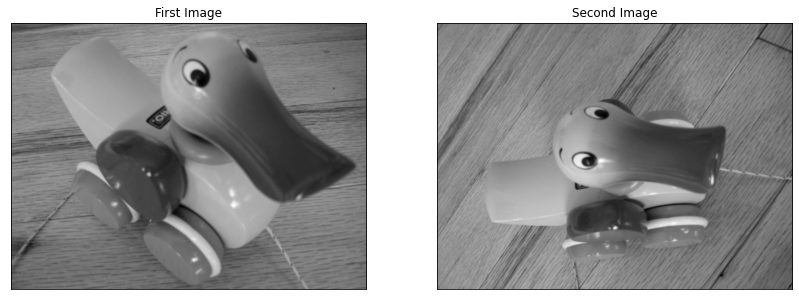

In [5]:
# Display the images
fig = plt.figure(figsize=(14,10))

# First image (object)
plt.subplot(121),plt.imshow(obj_img, cmap = 'gray')
plt.title('First Image'), plt.xticks([]), plt.yticks([])

# Second image (target)
plt.subplot(122),plt.imshow(target_img, cmap = 'gray')
plt.title('Second Image'), plt.xticks([]), plt.yticks([])
plt.show()

## Finding Keypoints & Descriptors Using ORB

First, we need to create/instantiate an ORB object (We are using ORB class from opencv) that is an alternative to SIFT or SURF

Then, we use that object to get keypoints and descriptors on both images separately

I decided to use ORB instead of SIFT because I found that ORB was able to find better keypoints & descriptors to match the ducks than SIFT

In [6]:
# Create the ORB object
orb = cv2.ORB_create()

# Get keypoints and descriptors for both images separately
# .detectAndCompute() is used to find keypoints and descriptors in a single step

# args --> target, mask
# returns --> keypoints, descriptors
keypoints_1, descriptors_1 = orb.detectAndCompute(obj_img, None)
keypoints_2, descriptors_2 = orb.detectAndCompute(target_img, None)

Visualizing the keypoints on both images:

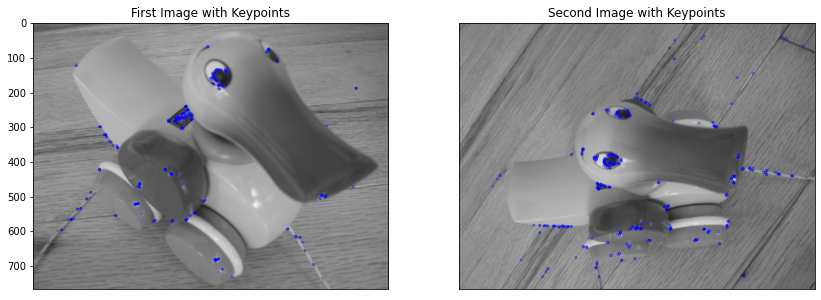

In [7]:
# Displaying both images with its keypoints
# Draw the keypoints on the image with color = blue
obj_img_keypoints = cv2.drawKeypoints(obj_img, keypoints_1, 0, (0,0,255))
target_img_keypoints = cv2.drawKeypoints(target_img, keypoints_2, 0, (0,0,255))

# Display
fig = plt.figure(figsize=(14,10))

# First image
plt.subplot(121),plt.imshow(obj_img_keypoints, cmap = 'gray')
plt.title('First Image with Keypoints'), plt.xticks([]), plt.yticks

# Second image
plt.subplot(122),plt.imshow(target_img_keypoints, cmap = 'gray')
plt.title('Second Image with Keypoints'), plt.xticks([]), plt.yticks([])
plt.show()

## Matching the Images (Using FlannBasedMatcher)

To use FLANN, we have to pass 2 dictionaries that specify the algorithm we are going to use, the parameters, etc.

They are IndexParams and SearchParams

In [8]:
# Buat object FLANN
# These index_params and search_params are believed to be good for ORB
index_params = dict(
    algorithm = 6,
    table_number = 6,
    key_size = 12,
    multi_probe_level = 1
)
search_params = dict()
flann= cv2.FlannBasedMatcher(index_params, search_params)

# We will get 2 best matches for each keypoints so that we can..
# ..apply ratio test
flann_matches = flann.knnMatch(descriptors_1, descriptors_2, k = 2)

Next step is to apply ratio test by D. Lowe

It is a method to filter keypoint matches that we just got by eliminating matches that are not good enough. If the 2 best matches that we got is not different enough, then it is considered not useful enough (information-wise) and we should eliminate it.

The formula to check it is:


```
if best_match < 2nd_best_match * constant:
  the best match is a good enough match
```

In this case, I will set the constant to be 0.75 (75%)

In [9]:
# Apply ratio test
good_matches = []
for pair in flann_matches: # Store the good matches
    try:
        m, n = pair
        if m.distance < (n.distance * 0.75):
            good_matches.append(m) # Add the good match
    except ValueError: pass

## Find homography using RANSAC algorithm

To match features, we usually need to find feature points from the first image and the second image and then find the best matches. These information is usually enough to find objects on both images

To achieve this, we can use .findHomography() function provided by opencv by passing set of points from both images. Then, it will find perspective transformation of the object we want to match/find. This function will return a mask that will specify the inliers and outliers points.

After that, we can use .perspectiveTransform() provided by opencv to actually find the object. Note that this process/algorithm requires at least 4 correct points to be able to find the transformation

RANSAC (Random sample consensus) algorithm is used to solve a problem which is when the result is bad because there are possible errors while matching. RANSAC algorithm is an outlier detection method. The good matches that provide correct estimation are called inliers and the rest are called outliers.

In [10]:
# Get the points of both images
obj_pts = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
target_pts = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

# Find the homography which will return the transformation matrix and the mask
M, mask = cv2.findHomography(obj_pts, target_pts, cv2.RANSAC, 5.0)

# Prepare the mask to be used for drawing matches
matchesMask = mask.ravel().tolist()

obj_height, obj_width = obj_img.shape

# Get pts to be transformed using .perspectiveTransform()
pts = np.float32([[0,0],[0,obj_height-1],[obj_width-1,obj_height-1],[obj_width-1,0]]).reshape(-1,1,2)

# Apply perspective transform on pts using M transformation matrix
dst = cv2.perspectiveTransform(pts,M)

# Get the target image
target_img = cv2.polylines(target_img,[np.int32(dst)], True, 255, 3, cv2.LINE_AA)

## Visualize the final result

The final step is to draw the matches on the images. We will use cv2.drawMatches()

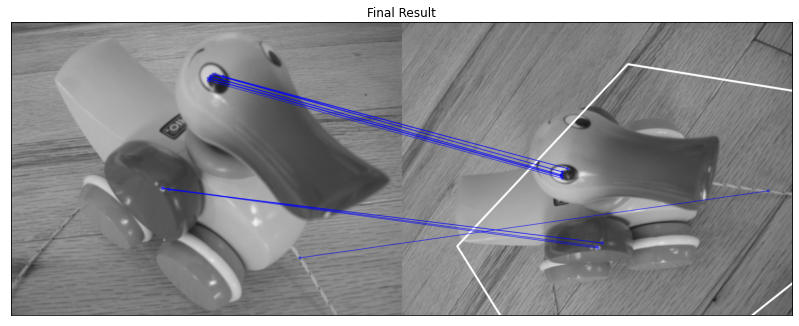

In [11]:
matched_img = cv2.drawMatches(
    obj_img, keypoints_1,
    target_img, keypoints_2,
    good_matches,
    None,
    singlePointColor = None,
    matchColor = (0,0,255), # draw matches in blue color
    matchesMask = matchesMask, # draw the inliers obtained from homography
    flags = 2 #only draw the matches (blue colored lines)
)

# Display the image
fig = plt.figure(figsize=(14,10))

# Suppressed thresholded R image
plt.imshow(matched_img, cmap='gray')
plt.title('Final Result'), plt.xticks([]), plt.yticks([])

plt.show()